- 馬体重
- 競馬場
- 月
- 年齢  
上記が高配当と全体で有意差がある状況

In [ ]:
import itertools
import warnings
from contextlib import redirect_stdout
import matplotlib.pyplot as plt
import matplotlib_fontja
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import statsmodels.formula.api as smf
import sweetviz as sv
from scipy.stats import chi2_contingency, chisquare, ttest_ind
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

warnings.filterwarnings("ignore")  # すべての警告を無視

c:\project\horse_ana\.venv4\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# pickleからデータ読み込み
results_df = pd.read_pickle("01_results_df.pickle")

In [3]:
# 細かい日付は今回不要として月のみ抽出
results_df["月"] = results_df["date"].str.extract(r'年(\d+)月')
# 馬体重表記をを増減と分ける
results_df[['馬体重', '馬体重_増減']] = results_df['馬体重'].str.extract(r'(\d+)\(([+-]?\d+)\)')
results_df['馬体重'] = pd.to_numeric(results_df['馬体重'], errors='coerce')
results_df['馬体重_増減'] = pd.to_numeric(results_df['馬体重_増減'], errors='coerce')
results_df["馬体重_増減"] = results_df["馬体重_増減"].fillna(0)
# 馬体重,人気null=出走取消として除外
results_df = results_df.dropna(subset=["馬体重","人気"])
# 性齢を性と年齢に分離
results_df[['性', '年齢']] = results_df['性齢'].str.extract(r'([牝牡セ])(\d+)')
results_df['年齢'] = pd.to_numeric(results_df['年齢'], errors='coerce')

# 探索的データ分析

複勝配当上位15%にHighPayoutHorseフラグを付けた

In [4]:
print(results_df["HighPayoutHorse"].value_counts())

HighPayoutHorse
0    90817
1     2053
Name: count, dtype: int64


## 高配当フラグ馬の競馬場別割合

競馬場
中山    306
東京    300
京都    276
新潟    211
中京    206
阪神    201
小倉    187
福島    165
札幌    117
函館     84
Name: count, dtype: int64


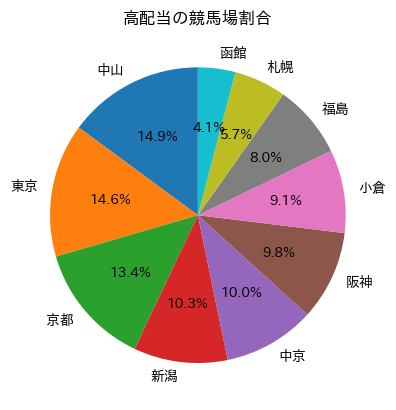

In [5]:
s = results_df.loc[results_df["HighPayoutHorse"] == 1, "競馬場"].value_counts()
print(s)
s.plot.pie(autopct='%1.1f%%', startangle=90);
plt.ylabel('')
plt.title("高配当の競馬場割合")
plt.show()

## 高配当フラグレースの競馬場別割合

競馬場
東京    1068
中山     994
京都     959
阪神     744
中京     731
新潟     642
小倉     548
福島     478
札幌     336
函館     288
Name: count, dtype: int64


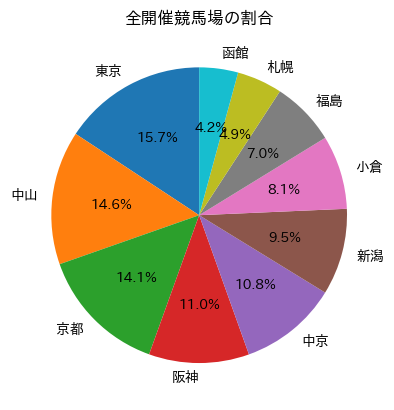

In [6]:
unique_race_df = results_df.drop_duplicates(subset="race_id")
keibajo_counts = unique_race_df["競馬場"].value_counts()
print(keibajo_counts)
keibajo_counts.plot.pie(autopct='%1.1f%%', startangle=90, title="全開催競馬場の割合");
plt.ylabel('')
plt.show()

馬別とレース別では若干割合が変わる

# 統計検定

## カテゴリ変数の有意差の検証

一部の変数について「高配当はレース分布に基づいた期待頻度で発生している（＝カテゴリ変数ごとに有意な差がある）」をカイ二乗検定

In [7]:
# 一部の変数について観測地と期待値を出力する
overall_df = results_df
high_payout_horse_df = results_df.loc[results_df["HighPayoutHorse"] == 1].copy()
cat_vars = ["競馬場", "馬番", "性齢","騎手", "調教師", "weather", "race_type", "ground_state", "所属", "月","性"]

with open("02_horse_categorical_chi2_results.txt", "w", encoding="utf-8") as outfile:
    with redirect_stdout(outfile):
        print("【変数の適合度検定】")
        for col in cat_vars:
            overall_counts = overall_df[col].value_counts().sort_index()
            overall_ratio = overall_counts / overall_counts.sum()
            observed = high_payout_horse_df[col].value_counts().sort_index()
            total_high = observed.sum()
            expected = overall_ratio * total_high
            all_index = overall_counts.index.union(observed.index)
            observed = observed.reindex(all_index, fill_value=0)
            expected = expected.reindex(all_index, fill_value=0)
            valid = expected > 0
            observed_valid = observed[valid]
            expected_valid = expected[valid]
            expected_valid = expected_valid * (observed_valid.sum() / expected_valid.sum())
            chi2_stat, p_val = chisquare(f_obs=observed_valid, f_exp=expected_valid)

            print(f"\n【{col}】")
            print("観測値:")
            print(observed)
            print("期待値:")
            print(expected)
            print(f"Chi-square = {chi2_stat:.3f}, p-value = {p_val:.3e}")
            if p_val < 0.05:
                print("→ 有意差あり（高配当馬と全体で分布が異なる可能性が高い）")
            else:
                print("→ 有意差なし（全体と分布が大きくは変わらない）")

- 性齢・騎手・調教師・性 -> 有意差あり
- 競馬場・月 -> 2024年データのみで検証した際は有意差があったものの、2023年データ追加後有意差なしに変化。

## 数値変数の有意差の検定

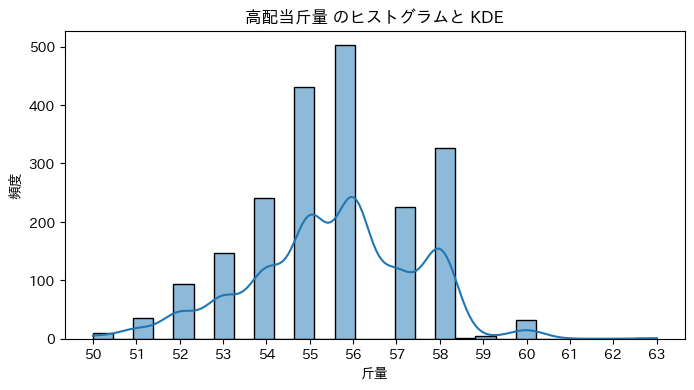

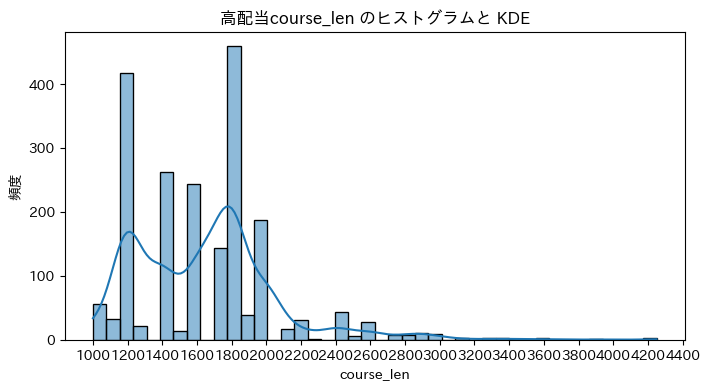

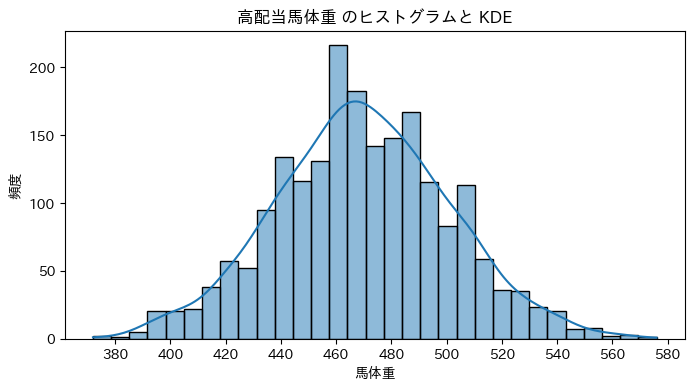

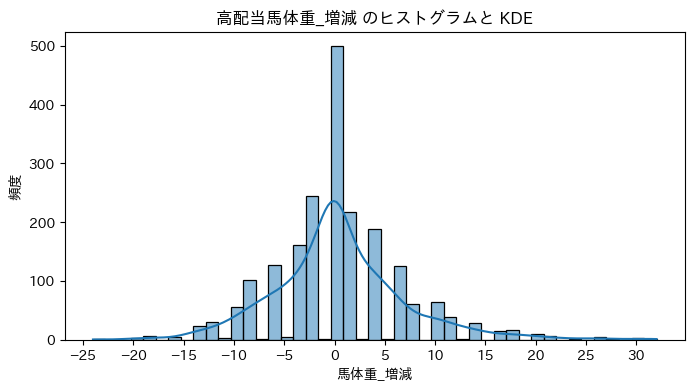

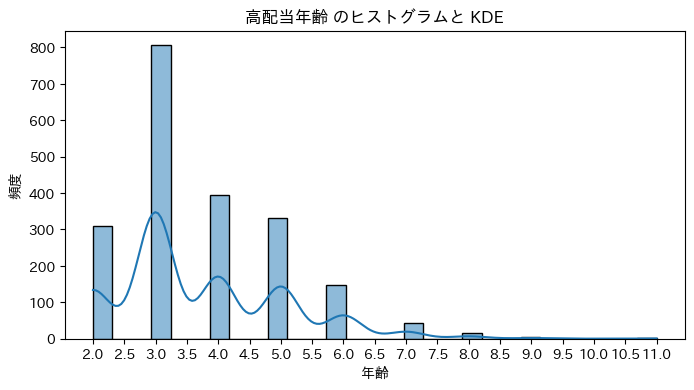

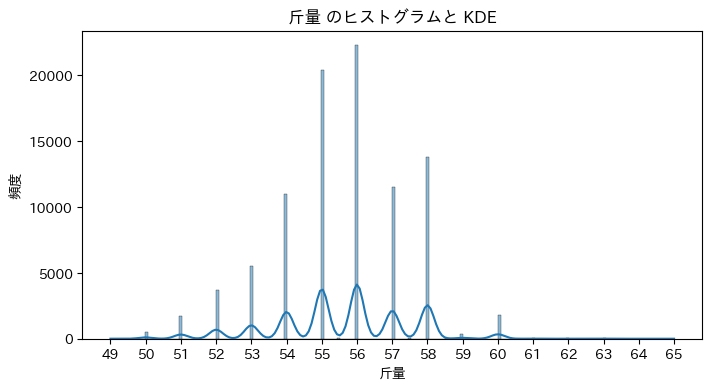

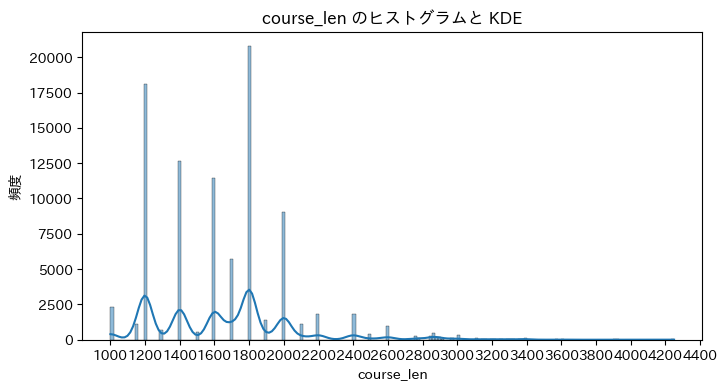

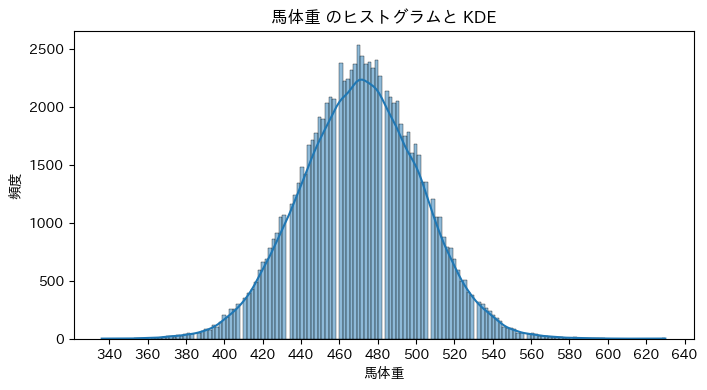

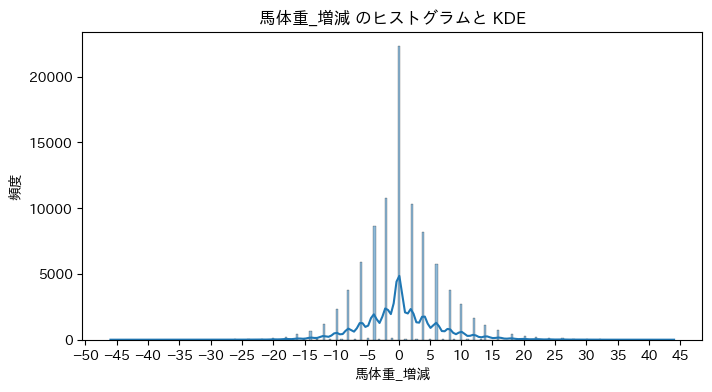

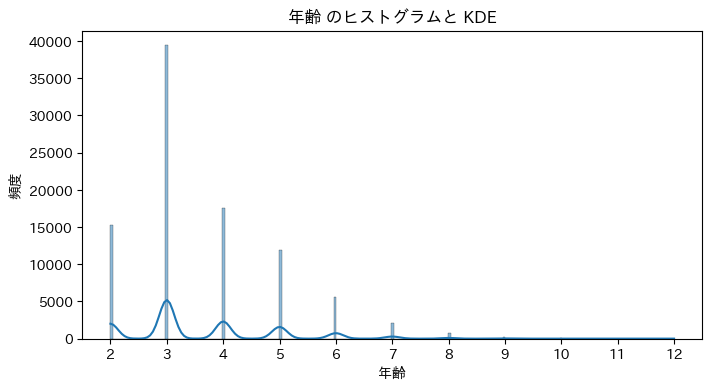

In [8]:
numeric_cols = ["斤量", "course_len", "馬体重", "馬体重_増減", "年齢"]

for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(high_payout_horse_df[col].dropna(), kde=True)
    plt.title(f"高配当{col} のヒストグラムと KDE")
    plt.xlabel(col)
    plt.ylabel("頻度")
    plt.locator_params(axis="x", nbins=20)
    plt.show()
for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(results_df[col].dropna(), kde=True)
    plt.title(f"{col} のヒストグラムと KDE")
    plt.xlabel(col)
    plt.ylabel("頻度")
    plt.locator_params(axis="x", nbins=20)
    plt.show()

## 馬体重と馬体重増減の検定

サンプル数が9万件超と多いため「等分散性の有無」を Levene 検定で判定し、その結果に応じて
  - 等分散あり: 通常の t検定
  - 等分散なし: Welch の t検定  

In [9]:
for col in ["馬体重", "馬体重_増減"]:
    overall = results_df[col].dropna()
    high    = high_payout_horse_df[col].dropna()
    
    # 等分散性の検定
    stat, p_var = stats.levene(overall, high, center="median")
    equal_var = (p_var >= 0.05)

    # t検定（等分散性に応じて切替）
    t_stat, p_val = stats.ttest_ind(high, overall, equal_var=equal_var)

    print(f"{col}: Levene p={p_var:.3f} → equal_var={equal_var}, "
          f"t={t_stat:.3f}, p={p_val:.3e}")

馬体重: Levene p=0.614 → equal_var=True, t=-2.091, p=3.656e-02
馬体重_増減: Levene p=0.090 → equal_var=True, t=0.509, p=6.107e-01


- 馬体重(p値≒0.045) 　: 小さい有意差あり
- 馬体重増減(p値≒0.8) : 有意差なし

## 斤量と距離の検定

- 斤量 : 馬ごとの負担重量
- 距離 : レース距離

斤量・距離はノンパラメトリックかつユニーク値が少ないため、カテゴリカル変数に置き換えて検定。

In [10]:
# 斤量のカテゴリ分け: [0, 53] が超軽、[54, 56]が軽、[57, 58] が標準、(58, ∞) が重
bins_weight = [0, 53, 56, 58, np.inf]
labels_weight = ["超軽斤量", "軽斤量", "標準斤量", "重斤量"]
results_df["斤量区分"] = pd.cut(results_df["斤量"], bins=bins_weight, labels=labels_weight, right=True)
high_payout_horse_df["斤量区分"] = pd.cut(high_payout_horse_df["斤量"], bins=bins_weight, labels=labels_weight, right=True)

In [11]:
# 距離をSMILE区分を参考にカテゴリ分け
bins_distance = [1000, 1301, 1900, 2101, 2701, np.inf]
labels_distance = ["Sprint", "Mile", "Intermediate", "Long", "Extended"]
results_df["距離区分"] = pd.cut(results_df["course_len"], bins=bins_distance, labels=labels_distance, right=False)
high_payout_horse_df["距離区分"] = pd.cut(high_payout_horse_df["course_len"], bins=bins_distance, labels=labels_distance, right=False)

In [12]:
# カテゴリ変数のリスト
cat_vars = ["斤量区分", "距離区分"]

# 保存するテキストファイルを指定して開く
with open("02_horse_numeric_chi2_results.txt", "w", encoding="utf-8") as outfile:
    # 標準出力を outfile にリダイレクト
    with redirect_stdout(outfile):
        print("【カテゴリ変数の適合度検定】")
        for col in cat_vars:
            # 全体分布：overall_df での各カテゴリの件数と割合
            overall_counts = overall_df[col].value_counts().sort_index()
            overall_ratio = overall_counts / overall_counts.sum()
            
            # 高配当イベント分布：high_payout_df での件数
            observed = high_payout_horse_df[col].value_counts().sort_index()
            total_high = observed.sum()
            
            # 全体の割合に基づく期待頻度
            expected = overall_ratio * total_high
            
            # 両者のインデックスを合わせる
            all_index = overall_counts.index.union(observed.index)
            observed = observed.reindex(all_index, fill_value=0)
            expected = expected.reindex(all_index, fill_value=0)
            
            # 期待値が0でないセルのみを対象にする
            valid = expected > 0
            observed_valid = observed[valid]
            expected_valid = expected[valid]
            
            # 期待値の合計を観測値の合計に合わせる
            expected_valid = expected_valid * (observed_valid.sum() / expected_valid.sum())
            
            chi2_stat, p_val = chisquare(f_obs=observed_valid, f_exp=expected_valid)
            
            print(f"\n【{col}】")
            print("観測値:")
            print(observed)
            print("期待値:")
            print(expected)
            print(f"Chi-square = {chi2_stat:.3f}, p-value = {p_val:.3e}")
            
            # 有意差の判定（5%水準）
            if p_val < 0.05:
                print("→ 有意差あり（分布が全体と異なる可能性が高い）")
            else:
                print("→ 有意差なし（分布は全体と同じと考えられる）")

斤量・距離ともに有意差はない

## 年齢の有意差検定

ノンパラメトリックかつ対応がないため、マンホイットニーのU検定

In [13]:
# 全体の年齢データと高配当群の年齢データ（欠損値除外）
overall_age = results_df["年齢"].dropna()
high_age = high_payout_horse_df["年齢"].dropna()

# Mann-Whitney U検定の実施
u_stat, p_value_age = stats.mannwhitneyu(high_age, overall_age, alternative="two-sided")
print(f"年齢 (Mann-Whitney U): U-statistic = {u_stat:.3f}, p-value = {p_value_age:.3e}")

年齢 (Mann-Whitney U): U-statistic = 100165330.500, p-value = 3.696e-05


年齢は有意差がある

## 多重共線性の確認

カテゴリ変数については木系モデル利用予定のため確認せず。

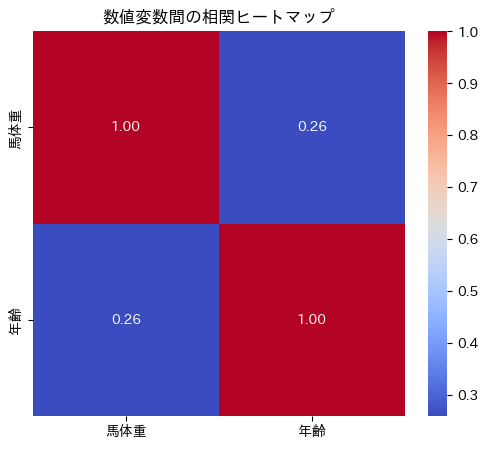

【VIFによる多重共線性確認】
    変数     VIF
0  馬体重  1.0715
1   年齢  1.0715


In [14]:
num_cols = ["馬体重", "年齢"]
df_num = results_df[num_cols].dropna().copy()

# 相関ヒートマップ
plt.figure(figsize=(6, 5))
sns.heatmap(df_num.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("数値変数間の相関ヒートマップ")
plt.show()

# VIF の計算
X = df_num.assign(Intercept=1)
vif_data = pd.DataFrame({
    "変数": X.columns,
    "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})

# Intercept 列は除外して表示
print("【VIFによる多重共線性確認】")
print(vif_data[vif_data["変数"] != "Intercept"])

馬体重と年齢に多重共線性は見られない

# 高配当率組み合わせ

高配当の下限が620円のため、配当が100％を超える期待値16.6％以上の組み合わせを見てみる。

学習後の解釈しやすさを目的に、今回は馬体重と年齢をbin分けする。

In [20]:
results_df['馬体重_bin'] = pd.qcut(results_df['馬体重'], q=7)
age_bins = [2, 3, 4, 5, 12]  # 2歳, 3歳, 4歳, 5歳以上
age_labels = ['2歳','3歳','4歳','5歳以上']
results_df['年齢_bin'] = pd.cut(results_df['年齢'], bins=age_bins,
                             labels=age_labels, right=True, include_lowest=True)

In [ ]:
# カテゴリ変数のリスト
cat_vars = ['騎手', '調教師', 'weather', 'race_type', 'ground_state',
            '所属', '競馬場', '性', '斤量区分',
            '距離区分', '馬体重_bin', '年齢_bin', '馬体重_bin']
cat_vars = list(dict.fromkeys(cat_vars))

# 全体平均高配当率
overall_rate = results_df['HighPayoutHorse'].mean()

# 組み合わせごとの高配当率を作成
combo_list = []
for r in [2, 3]:
    for vars_combo in itertools.combinations(cat_vars, r):
        grp = results_df.groupby(list(vars_combo), dropna=False)
        total = grp.size()
        high = grp['HighPayoutHorse'].sum()
        rate = high / total
        diff = rate - overall_rate

        df = pd.DataFrame({
            **{vars_combo[i]: total.index.get_level_values(i) for i in range(r)},
            '総数': total.values,
            '高配当数': high.values,
            '高配当率': rate.values,
            '率差': diff.values
        })
        df['組み合わせ長'] = r
        df['組み合わせ'] = '×'.join(vars_combo)
        combo_list.append(df)

combo_df = pd.concat(combo_list, ignore_index=True)

# ---- 4) フィルタ：「総数>=10 & 高配当率>=0.15」＋ 降順ソート ----
def filter_and_sort(df, r_len):
    filtered = df[(df['組み合わせ長'] == r_len) &
                  (df['総数'] >= 10) &
                  (df['高配当率'] >= 0.166)].copy()
    filtered = filtered.sort_values(['高配当率', '総数'], ascending=[False, False])

    if not filtered.empty:
        # 行ごとにその行の「組み合わせ」からキーを作成
        def _build_combo(row):
            cols = str(row['組み合わせ']).split('×')  # 例: ['騎手','調教師']
            parts = []
            for col in cols:
                val = row[col] if col in row.index else np.nan
                parts.append(f"{val}" if pd.notna(val) else f"{col}=欠損")
            return ' × '.join(parts)

        filtered['該当組み合わせ'] = filtered.apply(_build_combo, axis=1)

    # 列順（共通部のみ固定、キー列はそのまま後ろで保持）
    cols_front = ['組み合わせ長', '組み合わせ', '該当組み合わせ',
                  '総数', '高配当数', '高配当率', '率差']
    other_cols = [c for c in filtered.columns if c not in cols_front]
    filtered = filtered[cols_front + other_cols]

    return filtered

top2 = filter_and_sort(combo_df, 2)
top3 = filter_and_sort(combo_df, 3)

# ---- 5) CSV 出力（UTF-8 BOM付き）----
top2.to_csv("02_horse_vars_combo_rates_pairs_filtered.csv", index=False, encoding="utf-8-sig")
top3.to_csv("02_horse_vars_combo_rates_triples_filtered.csv", index=False, encoding="utf-8-sig")

騎手や調教師のいずれかが含まれていることが多いと見受けられる。

# 枠順特徴量の作成

レースごとに出走頭数が違うため、枠順に関するカラムを追加する。

In [23]:
# レースごとの出走頭数
results_df['出走頭数'] = results_df.groupby('race_id')['馬番'].transform('max')

# レースごとの相対枠位置（0=最内, 1=大外）
results_df['相対枠位置'] = results_df['馬番'] / results_df['出走頭数']

# 大外枠・最内枠フラグ
results_df['大外枠'] = (results_df['馬番'] == results_df['出走頭数']).astype(int)
results_df['最内枠'] = (results_df['馬番'] == 1).astype(int)

# 直近成績特徴量の作成

直近成績に関するカラムを追加する

In [27]:
results_df["horse_id"] = results_df["horse_id"].astype(int)
df = results_df.copy()

# 日付を datetime に変換（「YYYY年M月D日」→ YYYY-MM-DD）
def to_datetime_ja(s: pd.Series) -> pd.Series:
    ss = s.astype(str).str.replace(r'年|月', '-', regex=True).str.replace('日','', regex=False)
    return pd.to_datetime(ss, errors='coerce')

df['date'] = to_datetime_ja(df['date'])

# 着順を数値化（競走中止などは NaN）
df['着順_num'] = pd.to_numeric(df['着順'], errors='coerce')

# 3着以内の場合複勝フラグを設定
win_place_show_flag = (df['着順_num'] <= 3).astype(float)
win_place_show_flag = win_place_show_flag.fillna(0.0)
df['複勝フラグ'] = win_place_show_flag

# race_idとdateで並び順を設定
sort_keys = ['horse_id', 'date', 'race_id'] if 'race_id' in df.columns else ['horse_id', 'date']
df = df.sort_values(sort_keys).reset_index(drop=True)

# 直近成績
def rolling_rate(series, window, min_periods):
    return series.shift().rolling(window, min_periods=min_periods).mean()

df['馬_直近3走_複勝率']  = df.groupby('horse_id')['複勝フラグ'].transform(lambda s: rolling_rate(s, 3, 1))
df['馬_直近5走_複勝率']  = df.groupby('horse_id')['複勝フラグ'].transform(lambda s: rolling_rate(s, 5, 1))
df['馬_直近10走_複勝率'] = df.groupby('horse_id')['複勝フラグ'].transform(lambda s: rolling_rate(s,10, 3))

# 直近平均着順
df['馬_直近5走_平均着順'] = df.groupby('horse_id')['着順_num'].transform(
    lambda s: s.shift().rolling(5, min_periods=1).mean()
)

# 騎手・調教師の直近成績
_jockey_key = 'jockey_id' if 'jockey_id' in df.columns else '騎手'
_trainer_key = '調教師'

df['騎手_直近30走_複勝率'] = df.groupby(_jockey_key)['複勝フラグ'].transform(
    lambda s: rolling_rate(s, 30, 5)
)
df['調教師_直近50走_複勝率'] = df.groupby(_trainer_key)['複勝フラグ'].transform(
    lambda s: rolling_rate(s, 50, 5)
)

# レースコース適正
if 'race_type' in df.columns:
    df['馬_コース適性_複勝率'] = (
        df.groupby(['horse_id', 'race_type'])['複勝フラグ']
          .transform(lambda s: s.shift().expanding(min_periods=3).mean())
    )

# レース距離適性
if '距離区分' in df.columns:
    df['馬_距離適性_複勝率'] = (
        df.groupby(['horse_id', '距離区分'])['複勝フラグ']
          .transform(lambda s: s.shift().expanding(min_periods=3).mean())
    )

# 調教師・騎手コンビの直近成績
if _jockey_key in df.columns and _trainer_key in df.columns:
    df['コンビ_直近50走_複勝率'] = (
        df.groupby([_jockey_key, _trainer_key])['複勝フラグ']
          .transform(lambda s: rolling_rate(s, 50, 5))
    )

# 欠損を平均で埋める
for c in ['馬_直近3走_複勝率','馬_直近5走_複勝率','馬_直近10走_複勝率',
          '馬_直近5走_平均着順','騎手_直近30走_複勝率','調教師_直近50走_複勝率',
          '馬_コース適性_複勝率','馬_距離適性_複勝率','コンビ_直近50走_複勝率']:
    if c in df.columns:
        if c.endswith('平均着順'):
            df[c] = df[c].fillna(df[c].mean())
        else:
            df[c] = df[c].fillna(df['複勝フラグ'].mean())

# 単勝オッズ特徴量の作成

In [28]:
# 数値化・極端値で学習が不安定にならないよう上限カット
df["単勝"] = pd.to_numeric(df["単勝"], errors="coerce")
df["単勝"] = df["単勝"].clip(upper=df["単勝"].quantile(0.999))  # 任意

# 歪み補正のためログ変換
df["log単勝"] = np.log1p(df["単勝"])

# レース内ランク（小さい=人気、大きい=穴）
df["単勝ランク"] = df.groupby("race_id")["単勝"].rank(method="average")

# レース内パーセンタイル（0=最も人気、1=最も穴）
df["単勝pct"] = df.groupby("race_id")["単勝"].transform(
    lambda s: (s.rank(method="average") - 1) / (len(s) - 1 + 1e-9)
)

# 1番人気とのオッズ差（穴度合いの指標）
fav_odds = df.groupby("race_id")["単勝"].transform("min")
df["単勝_最人気差"] = df["単勝"] - fav_odds

# 上位人気とのギャップ（2番人気まで）
def topk_gap(s, k=2):
    v = np.sort(s.values)[:k]
    if len(v) < k: 
        return pd.Series([np.nan]*len(s), index=s.index)
    gap = s - v[k-1]
    return gap

df["単勝_2番人気差"] = df.groupby("race_id")["単勝"].transform(lambda s: topk_gap(s, k=2))


# 出力

In [29]:
df.to_pickle("02_horse_results_df.pickle")